# Medial Axis grid to graph
Research Notebook to create a graph from the Medial Axis grid

## Imports

In [1]:
import numpy as np
from skimage.morphology import medial_axis
from skimage.util import invert
from planning_utils import create_grid_no_height
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [3]:
print('start')
drone_altitude = 5
safety_distance = 3
grid = create_grid_no_height(data, drone_altitude, safety_distance)
print('done')

start
done


## Load from pickle

In [4]:
import pickle

pkl_filename = 'graph.medialaxis.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    skeleton = dist_pickle['skeleton']

print('done')

Reading pickle
done


## Visualize graph

start


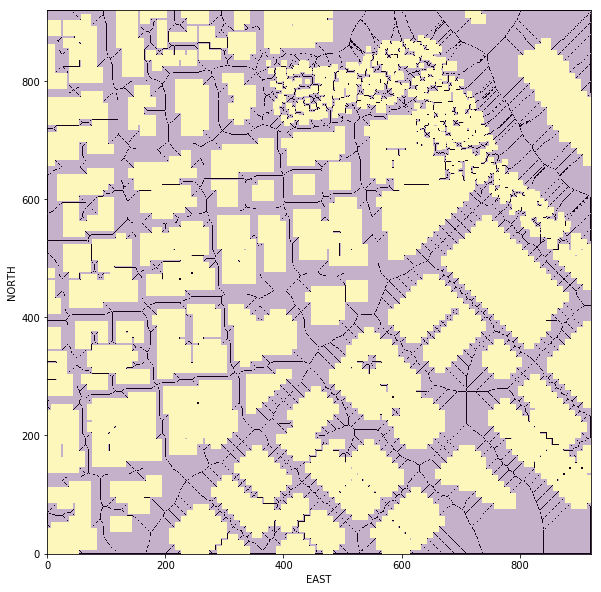

done


In [5]:
import matplotlib.pyplot as plt
print('start')
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## To Graph

In [6]:
from sampling import Sampler
nodes = tuple(map(tuple, np.transpose(skeleton.nonzero())))
#print(nodes)

print('Sampling')
t0 = time.time()
sampler = Sampler(data)
polygons = sampler.polygons
print('Sampling took {0} for {1}'.format(time.time()-t0, len(nodes)))

Sampling
Sampling took 0.17937970161437988 for 28304


In [7]:
import networkx as nx
nx.__version__

import numpy.linalg as LA
from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, Point, LineString

def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l):# and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                dist = LA.norm(np.array(n2) - np.array(n1))
                g.add_edge(n1, n2, weight=dist)
    return g

print('Creating Graph')
t0 = time.time()
g = create_graph(nodes, 2)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating Graph
Graph took 417.941876411438 seconds to build


In [8]:
print('Graph nodes: %5d' % len(g.nodes))
print('Graph edges: %5d' % len(g.edges))

Graph nodes: 27959
Graph edges: 21589


## Visualize graph

In [ ]:
import matplotlib.pyplot as plt

print('start')
fig = plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.5)

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1]-emin, n2[1]-emin], [n1[0]-nmin, n2[0]-nmin], 'black', alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1]-emin, n1[0]-nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1]-emin, n1[0]-nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

print("...done")

start


## Visualize graph

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()